# Visualizations

## Imports

In [1]:
import pandas as pd
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval
import wordcloud
import matplotlib.pyplot as plt

import ipywidgets as widgets
import plotly.subplots as sp
import matplotlib
import ipywidgets as widgets
from IPython.display import clear_output, display
from sklearn import preprocessing

## Globals

In [102]:
# True when the artist should be removed when he contains one of the genres
# False when only the genres of the aritst should be removed
REMOVE_ARTIST = True
NOTEBOOK = True

In [103]:
if NOTEBOOK:
    FIG_HEIGHT = 500
    FIG_WIDTH = 1000
else: 
    FIG_HEIGHT = 1200
    FIG_WIDTH = 2000

## Preprocessing

### Find the biggest genres

In [3]:
remove_genres = ["classical", "jazz", "folk", "french", "turkish", "gospel", "samba", "piano", "mpb", "sertanejo", "pagode", "sleep", "forro", "malay", "anime", 
                 "j-idol", "comedy", "mandopop", "cantopop", "show-tunes", "emo", "romance", "j-dance", "chill", "world-music", "iranian", "idm", "metalcore", 
                 "hardstyle", "opera", "k-pop", "j-pop", "j-rock", "happy"]

In [4]:
by_isrc = pd.read_csv('data/checkpoint/by_isrc_oldest.csv')

In [5]:
by_isrc_sub = by_isrc.copy()
by_isrc_sub = by_isrc_sub[['isrc', 'genres', 'year']]
by_isrc_sub.shape

(415124, 3)

In [6]:
if REMOVE_ARTIST:
    by_isrc_sub = by_isrc_sub[~by_isrc_sub['genres'].str.contains('|'.join(remove_genres))]
    by_isrc_sub['genres'] = by_isrc_sub['genres'].apply(literal_eval)
    df = by_isrc_sub.copy()
    df.drop(columns='year', inplace=True)
    by_isrc_sub = by_isrc_sub.explode('genres')
else:
    by_isrc_sub['genres'] = by_isrc_sub['genres'].apply(literal_eval)
    by_isrc_sub = by_isrc_sub.explode('genres')
    by_isrc_sub = by_isrc_sub[~by_isrc_sub['genres'].str.fullmatch('|'.join(remove_genres))]
    df = pd.DataFrame(by_isrc_sub.groupby('isrc')['genres'].apply(list))
by_isrc_sub.shape

(400129, 3)

In [9]:
df = df.merge(by_isrc.drop(columns='genres'), how='left', on='isrc')

In [10]:
df

,isrc,genres,name,artists,album,release_date,release_date_precision,uri,spotify_id,chart_power,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
0,AEA0Q1900049,[pop],asi jina sohneyan,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:4gEJ7dAwc67EMzojM8yZW8,4gEJ7dAwc67EMzojM8yZW8,NaN,...,1,0.0718,0.773,0.000004,0.3660,0.857,106.167,326430,4,1989
1,AEA0Q1900050,[pop],oh na ro dil merey tun,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:1sfQm4tPUxutEyX89xBNKd,1sfQm4tPUxutEyX89xBNKd,NaN,...,1,0.0746,0.819,0.000000,0.1260,0.847,127.191,383388,4,1989
2,AEA0Q1900051,[pop],nazaraan tun dur ho kay,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:4lynOHGcyNVvReUJ8ivLXr,4lynOHGcyNVvReUJ8ivLXr,NaN,...,1,0.0373,0.677,0.000001,0.0769,0.965,118.307,389803,4,1989
3,AEA0Q1900052,[pop],koyi raawan ch beh (mahiye),akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:5GIYaE4QwbbTxDdI0KfoiX,5GIYaE4QwbbTxDdI0KfoiX,NaN,...,1,0.0502,0.735,0.001930,0.2080,0.791,110.104,724500,4,1989
4,AEA0Q1900053,[pop],ja ni tun khushiyan maaney,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:0T2eReINvdY0aiAko9Tss7,0T2eReINvdY0aiAko9Tss7,NaN,...,1,0.0436,0.777,0.000000,0.1400,0.929,124.521,421667,4,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219667,ved049201120,"[pop, rock]",un instante mas,aditus,Algo Electrico,1987-08-11,day,spotify:track:6CtdVqvV108J7ZMkraNWae,6CtdVqvV108J7ZMkraNWae,NaN,...,1,0.0342,0.757,0.000005,0.8160,0.500,140.075,236983,4,1987
219668,ved049201121,"[pop, rock]",ella tiene (no se que),aditus,Algo Electrico,1987-08-11,day,spotify:track:0Tz2QPTjwxlEKIC62ho9Hj,0Tz2QPTjwxlEKIC62ho9Hj,NaN,...,1,0.0977,0.785,0.000000,0.6460,0.627,158.529,212509,4,1987
219669,ved049201554,"[pop, rock]",la ultima carta,aditus,Algo Electrico,1987-08-11,day,spotify:track:0SllqDSKFLgprVFEGybJta,0SllqDSKFLgprVFEGybJta,NaN,...,1,0.0344,0.747,0.000000,0.6600,0.430,80.388,246410,4,1987
219670,ved049201555,"[pop, rock]",la vida no me alcanzara,aditus,Algo Electrico,1987-08-11,day,spotify:track:4Y7scZtprxUexjnLTC0u3R,4Y7scZtprxUexjnLTC0u3R,NaN,...,1,0.0412,0.778,0.000027,0.3590,0.898,149.152,215574,4,1987


In [11]:
by_isrc_sub['count'] = 0

In [12]:
top_genres = pd.DataFrame(by_isrc_sub.groupby('genres')['count'].count()).sort_values(by='count', ascending=False)[:10]

In [13]:
top_genres

,count
genres,
pop,93002
rock,75737
punk,21593
metal,14063
country,11674
hard-rock,10377
german,10214
punk-rock,8794
blues,8380


In [14]:
top_genres_per_year = pd.crosstab(by_isrc_sub['year'],by_isrc_sub['genres'])

In [15]:
top_genres_per_year[list(top_genres.index)]

genres,pop,rock,punk,metal,country,hard-rock,german,punk-rock,blues,swedish
year,,,,,,,,,,
1980,9141,6667,2003,694,1340,885,584,907,933,774
1981,8338,6662,2200,686,1421,805,611,920,806,903
1982,8671,7036,2272,735,0,1001,807,807,774,774
1983,7722,6826,2165,1004,1135,1010,695,838,710,809
1984,9524,6970,2135,1399,982,1099,823,878,711,739
1985,9051,7210,2017,1431,1215,1001,815,755,458,760
1986,8811,7274,2056,1598,1240,1036,1080,853,638,669
1987,9119,8672,2010,2097,1416,1288,1292,905,816,795
1988,10602,8696,2395,2081,1466,1103,1714,926,1059,845


## Development of features over the years

In [29]:
# currently not used
save = df.copy()
df['year_month'] = 0
for index, song in df.iterrows():
    df.loc[index,'year_month'] = song['year']
    if song['release_date_precision'] == 'month':
        df.loc[index,'year_month'] += int(song['release_date'][5:7]) / 12


In [30]:
per_year_features = ['year', 'popularity', 'danceability', 'energy',
                     'key', 'loudness', 'mode', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness',
                     'valence', 'tempo', 'duration_ms',
                     'time_signature']
per_year_agg = {
    "popularity": 'mean',
    'danceability': 'mean', 
    'energy': 'mean',
    'key': 'mean', 
    'loudness': 'mean', 
    'mode': 'mean', 
    'speechiness': 'mean',
    'acousticness': 'mean', 
    'instrumentalness': 'mean', 
    'liveness': 'mean',
    'valence': 'mean', 
    'tempo': 'mean', 
    'duration_ms': 'mean',
    'time_signature': 'mean',
    'count': 'count'
}

songs_per_year = df.copy()
songs_per_year = songs_per_year[per_year_features]
songs_per_year['count'] = -1
songs_per_year = songs_per_year.groupby("year").agg(per_year_agg)
songs_per_year.reset_index(inplace=True)
songs_per_year['duration_min'] = songs_per_year['duration_ms'] / (1000 * 60)
songs_per_year = songs_per_year.astype({'year': str})

In [104]:
features = ["danceability", "energy", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
fig = go.Figure()

for feature in features:
    fig.add_trace(go.Scatter(
    x=songs_per_year['year'],
    y=songs_per_year[feature],
    name=feature
))

fig.update_layout(
    height = FIG_HEIGHT,
    width = FIG_WIDTH,
    #yaxis_title='Popularity',
    xaxis_title='year',
    title='Development of features',
    template='plotly_dark',
    yaxis_range=[0,1]
)

fig.show()

In [106]:
features = [
    {
        "title": "Tempo (bpm)",
        "value": "tempo",
        "range": [110, 130]
    },
    {
        "title": "Duration (min)",
        "value": "duration_min",
        "range": [3, 5]
    },
    {
        "title": "Loudnes (dB)",
        "value": "loudness",
        "range": [0, -20]
    },
    {
        "title": "Songs released",
        "value": "count",
        "range": [0, 50000]
    }
]

In [107]:
for feature in features:
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=songs_per_year['year'],
        y=songs_per_year[feature["value"]],
        name=feature["value"]
    ))
    
    fig.update_layout(
        height = FIG_HEIGHT,
        width = FIG_WIDTH,
        yaxis_title=feature["title"],
        xaxis_title='year',
        title='Development of features',
        template='plotly_dark',
        yaxis_range=feature["range"]
    )
    
    fig.show()

In [108]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=songs_per_year['year'],
    y=songs_per_year['popularity'],
    name='Duration (ms)'
))

#fig.add_trace(go.Scatter(
#    x=df['year_month'],
#    y=df['duration_ms'],
#    mode='markers',
#    name='Duration (ms) - markers'
#))

# Define the dropdown menu options
dropdown_options = [
    #{'label': 'Duration (ms)', 'value': 'duration_ms', 'range': []},
    {'label': 'Popularity', 'value': 'popularity', 'range': [0,10]},
    {'label': 'Danceability', 'value': 'danceability', 'range': [0,1]},
    {'label': 'Energy', 'value': 'energy', 'range': [0,1]},
    #{'label': 'Key', 'value': 'key', range: [0,1]},
    {'label': 'Loudness', 'value': 'loudness', 'range': [0,-20]},
    {'label': 'Mode', 'value': 'mode', 'range': [0,1]},
    {'label': 'Speechiness', 'value': 'speechiness', 'range': [0,1]},
    {'label': 'Acousticness', 'value': 'acousticness', 'range': [0,1]},
    {'label': 'Instrumentalness', 'value': 'instrumentalness', 'range': [0,1]},
    {'label': 'Liveness', 'value': 'liveness', 'range': [0,1]},
    {'label': 'Valence', 'value': 'valence', 'range': [0,1]},
    {'label': 'Tempo', 'value': 'tempo', 'range': [100, 130]},
    {'label': 'Time Signature', 'value': 'time_signature', 'range': [3,7]},
    {'label': 'Count', 'value': 'count', 'range': [0,50000]},
    {'label': 'Duration (min)', 'value': 'duration_min', 'range': [3,5]}
]

# Create the dropdown menu
dropdown_menu = go.layout.Updatemenu(
    buttons=list([
        dict(
            args=[
                {'y': [songs_per_year[option['value']]]}, 
                {'yaxis': {
                    'title': option['label'].capitalize(),
                    'range': option['range']
                }}
            ],
            label=option['label'],
            method='update'
        )
        for option in dropdown_options
    ]),
    direction='down',
    showactive=True,
)

fig.update_layout(
    height = FIG_HEIGHT,
    width = FIG_WIDTH,
    updatemenus=[dropdown_menu],
    yaxis_title='Popularity',
    xaxis_title='year',
    title='Development of features',
    template='plotly_dark',
    yaxis_range=[0,10]
)

fig.show()

## Development of genres of the years

In [110]:
features = list(top_genres.index)

In [111]:
dev_genres_df = top_genres_per_year.reset_index()

In [112]:
fig = go.Figure()

for feature in features:
    fig.add_trace(
        go.Scatter(
            x=dev_genres_df['year'],
            y=dev_genres_df[feature],
            name=feature
        )
    )
    
fig.update_layout(
    height = FIG_HEIGHT,
    width = FIG_WIDTH,
    #updatemenus=[dropdown_menu],
    yaxis_title='count',
    xaxis_title='year',
    title='Development of genres',
    template='plotly_dark',
    yaxis_rangemode='tozero'
)

fig.show()

In [113]:
# Create the initial scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dev_genres_df['year'],
    y=dev_genres_df['pop'],
    #mode='markers',
    name='Pop'
))

# Create the dropdown menu
dropdown_menu = go.layout.Updatemenu(
    buttons=list([
        dict(
            args=[
                {'y': [dev_genres_df[option]]}, 
                {'yaxis': {
                    'title': option.capitalize(),
                    'rangemode':'tozero'
                }}
            ],
            label=option,
            method='update'
        )
        for option in features
    ]),
    direction='down',
    showactive=True,
)

# Update the layout with dropdown menu and initial y-axis title
fig.update_layout(
    height = FIG_HEIGHT,
    width = FIG_WIDTH,
    updatemenus=[dropdown_menu],
    yaxis_title='pop',
    xaxis_title='year',
    title='Development of genres',
    template='plotly_dark',
    yaxis_rangemode='tozero'
)

fig.show()

## Add the genres to the features

In [39]:
df.head()

,isrc,genres,name,artists,album,release_date,release_date_precision,uri,spotify_id,chart_power,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,year_month
0,AEA0Q1900049,[pop],asi jina sohneyan,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:4gEJ7dAwc67EMzojM8yZW8,4gEJ7dAwc67EMzojM8yZW8,NaN,...,0.0718,0.773,0.000004,0.3660,0.857,106.167,326430,4,1989,1989.0
1,AEA0Q1900050,[pop],oh na ro dil merey tun,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:1sfQm4tPUxutEyX89xBNKd,1sfQm4tPUxutEyX89xBNKd,NaN,...,0.0746,0.819,0.000000,0.1260,0.847,127.191,383388,4,1989,1989.0
2,AEA0Q1900051,[pop],nazaraan tun dur ho kay,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:4lynOHGcyNVvReUJ8ivLXr,4lynOHGcyNVvReUJ8ivLXr,NaN,...,0.0373,0.677,0.000001,0.0769,0.965,118.307,389803,4,1989,1989.0
3,AEA0Q1900052,[pop],koyi raawan ch beh (mahiye),akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:5GIYaE4QwbbTxDdI0KfoiX,5GIYaE4QwbbTxDdI0KfoiX,NaN,...,0.0502,0.735,0.001930,0.2080,0.791,110.104,724500,4,1989,1989.0
4,AEA0Q1900053,[pop],ja ni tun khushiyan maaney,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:0T2eReINvdY0aiAko9Tss7,0T2eReINvdY0aiAko9Tss7,NaN,...,0.0436,0.777,0.000000,0.1400,0.929,124.521,421667,4,1989,1989.0


In [40]:
scaler = MinMaxScaler()
df_top_genres_features = df.copy()
df_top_genres_features = df_top_genres_features[['danceability', 'energy',
                       'key', 'loudness', 'mode', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness',
                       'valence', 'time_signature', 'tempo', 'genres']]
df_top_genres_features = df_top_genres_features.explode('genres')
df_top_genres_features.set_index('genres', inplace=True)
df_top_genres_features = pd.DataFrame(scaler.fit_transform(df_top_genres_features),
                                     columns = df_top_genres_features.columns,
                                     index = df_top_genres_features.index)
df_top_genres_features.reset_index(inplace=True)
df_top_genres_features = df_top_genres_features.groupby('genres').mean()
df_top_genres_features = df_top_genres_features.loc[df_top_genres_features.index.str.fullmatch('|'.join(features))]

In [41]:
df_top_genres_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo
genres,,,,,,,,,,,,
blues,0.548265,0.571817,0.472293,0.733599,0.755728,0.067434,0.348687,0.099424,0.251105,0.634823,0.765895,0.508360
country,0.581260,0.466344,0.464062,0.718086,0.915111,0.047096,0.437702,0.025624,0.210129,0.600594,0.772263,0.487032
german,0.459345,0.450599,0.481122,0.660392,0.686509,0.129203,0.539556,0.272386,0.218766,0.434567,0.760623,0.465617
hard-rock,0.423676,0.807770,0.492199,0.787642,0.667919,0.071841,0.070428,0.131336,0.320655,0.466943,0.789997,0.517088
metal,0.384719,0.833908,0.497152,0.790120,0.621347,0.081077,0.049012,0.187965,0.287595,0.398810,0.789149,0.512083
pop,0.562634,0.549540,0.469049,0.752331,0.693921,0.059193,0.449770,0.050966,0.219843,0.602902,0.773407,0.490384
punk,0.435371,0.780995,0.490719,0.779187,0.680591,0.082294,0.105474,0.196361,0.260267,0.522157,0.787338,0.525683
punk-rock,0.466842,0.764908,0.491120,0.775738,0.687514,0.075263,0.114855,0.195468,0.263788,0.551331,0.788970,0.528091
rock,0.528722,0.650753,0.478353,0.756449,0.708135,0.065446,0.240854,0.104354,0.248880,0.566943,0.784855,0.506150


## Create Radar Chart for the top 10 genres

In [45]:
top_genres_list = list(top_genres.index)
top_genres_list.append(top_genres_list[0])

In [114]:
fig = go.Figure()

for genre in top_genres_list:
    df_radar = pd.DataFrame(df_top_genres_features.loc[genre])
    df_radar.reset_index(inplace=True)
    df_radar.rename(columns={"index":"feature", genre: "mean"}, inplace=True)
    df_radar = pd.concat([df_radar, pd.DataFrame(df_radar.iloc[0]).T])
    
    fig.add_trace(go.Scatterpolar(
        r = df_radar['mean'],
        theta = df_radar['feature'],
        mode = 'lines',
        fill = 'none',
        name = genre
    ))
fig.update_layout(
    height = FIG_HEIGHT,
    width = FIG_WIDTH,
    template='plotly_dark'
)

fig.show()

## Word Cloud for Genres

In [115]:
genre_counts = top_genres.reset_index()

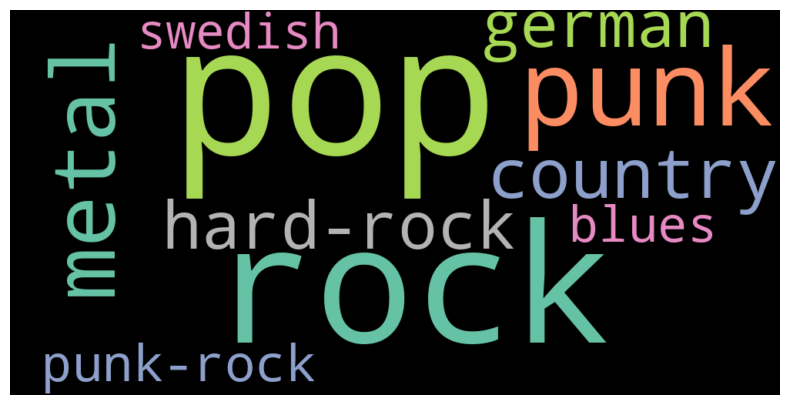

In [116]:
genre_counts = genre_counts.sort_values(by='count', ascending=False)
genre_counts_dict = genre_counts.set_index('genres')['count'].to_dict()
cloud = wordcloud.WordCloud(height = FIG_HEIGHT, width = FIG_WIDTH, background_color='black',colormap='Set2').generate_from_frequencies(genre_counts_dict)
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud for Genres per Year

There are several null values after pivot the dataframe, because some genres doesn't exist in some years. But it doesn't matter for our purpose

In [117]:
genres_by_year = top_genres_per_year.copy()

In [118]:
genres_by_year = genres_by_year.to_dict('index')

In [119]:
def wc(df):
    clear_output(wait=True)
    cloud = wordcloud.WordCloud(width=FIG_WIDTH, height=FIG_HEIGHT, background_color='black').generate_from_frequencies(df)
    plt.figure(figsize=(9, 9))
    plt.imshow(cloud)
    plt.tight_layout()
    plt.axis("off")

In [120]:
dropdown = widgets.Dropdown(options = genres_by_year,
                                value=genres_by_year[1980],
                                 description= "year" )

widgets.interact(wc,df=dropdown)

interactive(children=(Dropdown(description='year', options={1980: {'acoustic': 55, 'afrobeat': 30, 'alt-rock':…

<function __main__.wc(df)>

## Chart power of Artists in Word Cloud

split artists

In [69]:
df_artists = df.copy()
df_artists = df_artists.drop_duplicates(["name","year"])

In [70]:
print('Occurences of substring ", ": ' + str(len(df_artists.loc[df_artists["artists"].str.contains(', ')])))
print('Occurences of substring "_":' + str(len(df_artists.loc[df_artists["artists"].str.contains('_')])))

Occurences of substring ", ": 347
Occurences of substring "_":0


In [71]:
df_artists.loc[df_artists["artists"].str.contains(', '), 'artists'] = df_artists[df_artists["artists"].str.contains(', ')]['artists'].str.replace(', ', '_')

In [72]:
print('Occurences of substring ", ": ' + str(len(df_artists.loc[df_artists["artists"].str.contains(', ')])))
print('Occurences of substring "_":' + str(len(df_artists.loc[df_artists["artists"].str.contains('_')])))

Occurences of substring ", ": 0
Occurences of substring "_":347


In [73]:
df_artists['artists'] = df_artists['artists'].str.split(',')
df_split_artists = df_artists.explode('artists')

In [74]:
print('Occurences of substring ", ": ' + str(len(df_split_artists.loc[df_split_artists["artists"].str.contains(', ')])))
print('Occurences of substring "_":' + str(len(df_split_artists.loc[df_split_artists["artists"].str.contains('_')])))

Occurences of substring ", ": 0
Occurences of substring "_":347


In [75]:
df_split_artists.loc[df_split_artists['artists'].str.contains('_'), 'artists'] = df_split_artists[df_split_artists["artists"].str.contains('_')]['artists'].str.replace('_', ', ')

In [76]:
print('Occurences of substring ", ": ' + str(len(df_split_artists.loc[df_split_artists["artists"].str.contains(', ')])))
print('Occurences of substring "_":' + str(len(df_split_artists.loc[df_split_artists["artists"].str.contains('_')])))

Occurences of substring ", ": 347
Occurences of substring "_":0


In [77]:
df_split_artists["artists"].unique()

array(['akram rahi', 'walid toufic',
       'patricio rey y sus redonditos de ricota', ..., 'ava',
       'fereydun shahbazian', 'mohammad-reza shajarian'], dtype=object)

In [78]:
df_artist_chart_power_per_year = (
    df_split_artists.groupby(['year', 'artists'])
    .agg({'chart_power': 'sum'})
    .groupby('year', as_index=False)
    .apply(lambda group: group.nlargest(15, columns='chart_power'))
    .reset_index(level=0, drop=True)
    .reset_index()
    .pivot(index='year', columns='artists', values='chart_power')
    .fillna(0)
    .astype(float)
    .to_dict(orient='index')
)

In [79]:
dropdown = widgets.Dropdown(options = df_artist_chart_power_per_year,
                                value=df_artist_chart_power_per_year[1980],
                                 description= "year" )

widgets.interact(wc,df=dropdown)

interactive(children=(Dropdown(description='year', options={1980: {'a-ha': 0.0, 'abba': 5044.0, 'ac/dc': 1920.…

<function __main__.wc(df)>

## Chart Power of Artists in Word Cloud (All years)

In [80]:
df_chart_power_artists = df_split_artists.copy()

sum of chart score per artists

In [81]:
df_chart_power_artists = df_chart_power_artists.groupby("artists")["chart_power"].sum().reset_index()

Top 20 Chart Score Artists in Word Cloud

In [82]:
top20_chart = df_chart_power_artists.sort_values(['chart_power'],ascending=False).head(20)

In [121]:
def wordcloud_artists(counts):
    cloud = wordcloud.WordCloud(width=FIG_WIDTH, height=FIG_HEIGHT, background_color='black').generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

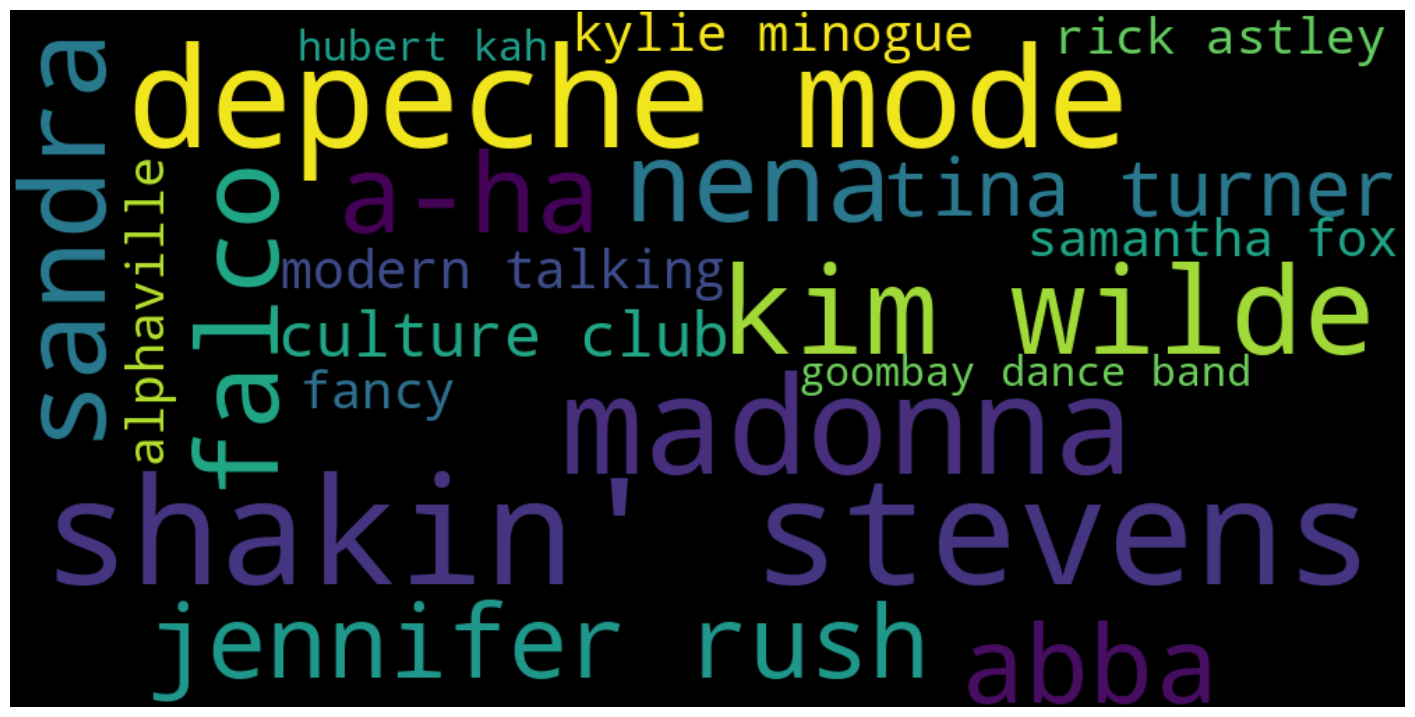

In [122]:
top20_chart_tuples = [tuple(x) for x in top20_chart.values]
wordcloud_artists(dict(top20_chart_tuples))

## Popularity of Artists in Word Cloud (All years)

In [123]:
df_split_artists.groupby("artists", as_index=False)["popularity"].sum()

,artists,popularity
0,"""colacho"" méndoza y su acordeón",10
1,'om' alec khaoli,1
2,'til tuesday,679
3,*nsync,11
4,000 maniacs,911
...,...,...
14192,趙一豪,1
14193,鈴木一郎,0
14194,黄凤凤,0
14195,黒住憲五,303


Problem: 

In [124]:
df_split_artists.loc[df_split_artists['artists'] == 'johann sebastian bach', 'popularity'].agg(['mean', 'min', 'max'])

mean     1.681905
min      0.000000
max     37.000000
Name: popularity, dtype: float64

In [130]:
df_popularity_artists = df_split_artists.groupby("artists", as_index=False)["popularity"].sum()

In [131]:
top20 = df_popularity_artists.sort_values(['popularity'],ascending=False).head(20)

In [132]:
top20

,artists,popularity
8226,metallica,7786
12739,the smiths,5753
13307,u2,5465
12329,the cure,5436
3816,fleetwood mac,4865
10033,r.e.m.,4731
2834,depeche mode,4660
3180,duran duran,4474
1619,bruce springsteen,4299
12025,talking heads,4128


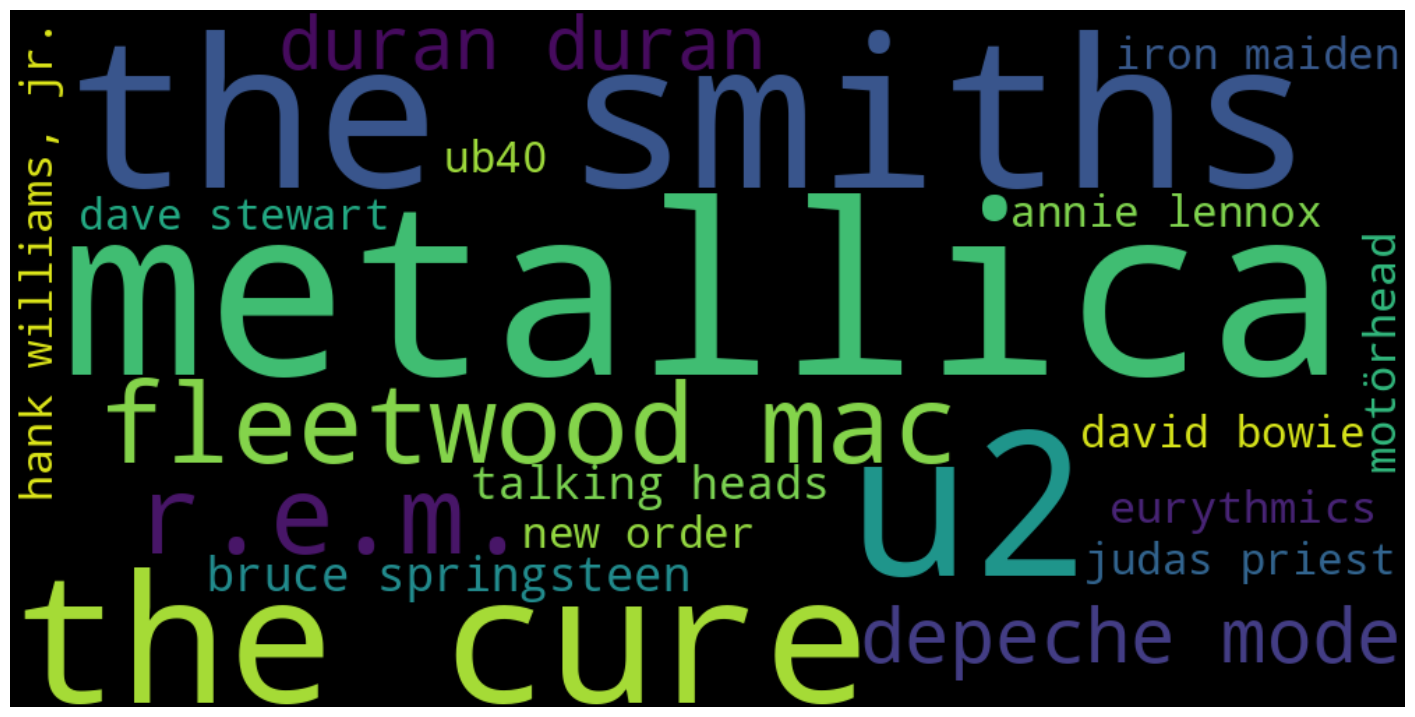

In [133]:
top20_tuples = [tuple(x) for x in top20.values]
wordcloud_artists(dict(top20_tuples))

## Comparison of Chart Power and Popularity for Artists

Merge popularity and chart score

In [91]:
df_comparison = df_popularity_artists.merge(df_chart_power_artists, on='artists',how="outer")
df_comparison['popularity'] = df_comparison['popularity'].fillna(0) #fill nan value to 0
df_comparison['chart_power'] = df_comparison['chart_power'].fillna(0)

### Top 20 popular Artists today vs. in the 80s

In [92]:
top20_popu = df_comparison.nlargest(20, 'popularity').reset_index(drop=True)
top20_score = df_comparison.nlargest(20, 'chart_power').reset_index(drop=True)

In [93]:
display(top20_popu, top20_score)

,artists,popularity,chart_power
0,metallica,7786,0.0
1,the smiths,5753,0.0
2,u2,5465,919.0
3,the cure,5436,0.0
4,fleetwood mac,4865,2583.0
5,r.e.m.,4731,0.0
6,depeche mode,4660,13828.0
7,duran duran,4474,5465.0
8,bruce springsteen,4299,1927.0
9,talking heads,4128,0.0


,artists,popularity,chart_power
0,shakin' stevens,1947,15475.0
1,depeche mode,4660,13828.0
2,madonna,2273,13295.0
3,kim wilde,2074,10246.0
4,sandra,940,9584.0
5,falco,1610,8702.0
6,nena,1400,8600.0
7,a-ha,2994,8365.0
8,abba,1737,7989.0
9,jennifer rush,973,6949.0


In [134]:
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Top 20 popular artists at the moment', 'Top 20 popular artists in the 80s'))

# Add bar trace for top popularity artists
fig.add_trace(go.Bar(x=top20_popu['popularity'], y=top20_popu['artists'],
                     orientation='h', name='Popularity Artists'), row=1, col=1)

# Add bar trace for top chart score artists
fig.add_trace(go.Bar(x=top20_score['chart_power'], y=top20_score['artists'],
                     orientation='h', name='Chart Score Artists'), row=1, col=2)

# Update layout
fig.update_layout(#title='Top 20 Artists',
                  yaxis=dict(autorange="reversed"),
                  yaxis2=dict(autorange="reversed"),
                  width=FIG_WIDTH,  # Width in pixels
                  height=FIG_HEIGHT,
                  template='plotly_dark'
                  
)

# Show the plot
fig.show()

### Top artists that were unpopular in the 80s but are popular today

In [95]:
def barplot(col1,col2,title):

    fig = go.Figure(data=go.Bar(
    x=col1,
    y=col2,
    orientation='h'
    ))

    fig.update_layout(
        title = title,
        xaxis=dict(
            range=[0.1, max(col1)+0.1],  # Set the range of the x-axis
            dtick=0.2  # Set the tick interval of the x-axis
        )
    )

    # Show the bar chart
    fig.show()

In [96]:
low_chart_power = df_comparison[df_comparison['chart_power'] < 50]
sorted_low_chart_power = low_chart_power.sort_values(by='popularity', ascending=False)
top_10_low_chart = sorted_low_chart_power.head(10)
top_10_low_chart

,artists,popularity,chart_power
8226,metallica,7786,0.0
12739,the smiths,5753,0.0
12329,the cure,5436,0.0
10033,r.e.m.,4731,0.0
12025,talking heads,4128,0.0
8581,motörhead,3946,0.0
4675,"hank williams, jr.",3935,0.0
644,annie lennox,3788,0.0
2616,dave stewart,3788,0.0
5290,iron maiden,3778,0.0


In [137]:
def barplot(df,col1,col2,title):
    fig = px.bar(
        data_frame = df,
        x = "artists",
        y = [col1,col2],
        opacity = 0.9,
        orientation = "v",
        barmode = 'group',
        title = title
    )
    
    fig.update_layout(
        height = FIG_HEIGHT,
        width = FIG_WIDTH,
        template='plotly_dark',
        yaxis_title='Popularity (sum)'
    )
    
    fig.show()

In [138]:
barplot(top_10_low_chart,top_10_low_chart.chart_power,top_10_low_chart.popularity,"Top10 Artists who had < 50 chart score but has now high popularity")

### Top artists that were popular in the 80s but are unpopular today

In [99]:
low_pop = df_comparison[df_comparison['popularity'] < 116]
sorted_low_pop = low_pop.sort_values(by='chart_power', ascending=False)
top_10_low_pop = sorted_low_pop.head(10)
top_10_low_pop

,artists,popularity,chart_power
9270,p. lion,46,2695.0
2018,chilly,21,2431.0
12959,tight fit,109,2103.0
3668,fairground attraction,95,1350.0
504,andreas martin,115,1145.0
4980,hithouse,105,1103.0
2631,david cassidy,40,1062.0
3804,five star,67,762.0
12906,thomas anders,85,641.0
10058,radiorama,59,565.0


In [139]:
barplot(top_10_low_pop,top_10_low_pop.chart_power,top_10_low_pop.popularity,"Top10 Artists who had high chart score but have now popularity < 10")

## Comparison of Chart Power and Popularity for Songs

Find the most popular songs